[Text(0.5, 0.75, 'Variability <= 0.093\ngini = 0.491\nsamples = 160\nvalue = [69, 91]\nclass = Deterioration'),
 Text(0.25, 0.25, 'gini = 0.0\nsamples = 69\nvalue = [69, 0]\nclass = Noise'),
 Text(0.375, 0.5, 'True  '),
 Text(0.75, 0.25, 'gini = 0.0\nsamples = 91\nvalue = [0, 91]\nclass = Deterioration'),
 Text(0.625, 0.5, '  False')]

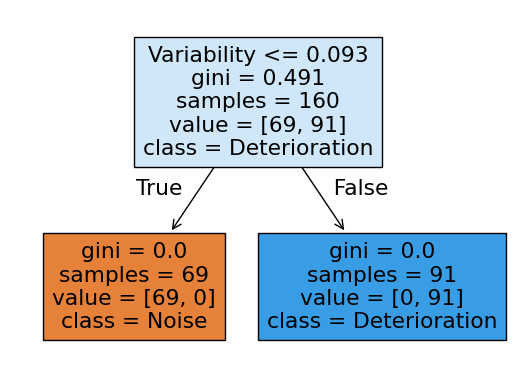

In [5]:
import numpy as np
import pandas as pd 

np.random.seed(42)

#### SIMULATED DATA GENERATION ####

# creating 200 patients 
n_patients = 200

# 10 lab measurements per patient 
n_timepoints = 10

# for storing rows in the form: Patient 12, time 3, value 1.8
data = []

# simulating one patient at a time 
for patient_id in range(n_patients):
    
    # assigning a baseline (normal) lab value for each patient
    # avergae of 1.0 and spread of 0.2
    baseline = np.random.normal(1.0, 0.2)
    # label source: 0 => noise only and 1 => real deterioration
    deteriorating = np.random.choice([0, 1])
    # signal from clinician intuition (voice logging)
    voice_concern = np.random.choice([0, 1])

    # simulating repeated labs
    for t in range(n_timepoints):
        # measurement variability 
        noise = np.random.normal(0, 0.05)
        # ensuring that labs drift upward over time if patient is deteriorating
        trend = t * 0.05 if deteriorating else 0
        # final lab value 
        lab_value = baseline + trend + noise 
        # storing everything 
        data.append([
            patient_id,
            t, 
            lab_value, 
            deteriorating,
            voice_concern
        ])

# longitudinal patient data to conceptually mirror ICU labs
df = pd.DataFrame(
    data,
    columns=["PatientID", "Time", "LabValue", "Outcome", "VoiceConcern"]
)

##### FEATURE EXTRACTION ######

### We compute: 
# mean(average lab), 
# slope(increasing or decreasing) 
# std dev(stable or not)
# last value (current state)

## GROUPING BY PATIENT 

features = []

# getting all the labs for one patient 
for patient_id, group in df.groupby("PatientID"):
    
    # extracting arrays
    times = group["Time"].values
    labs = group["LabValue"].values
    
    # trend detection: positive slope => worsening, near zero => noise
    slope = np.polyfit(times, labs, 1)[0]

    # data frame with patients as rows instead of lab for ml algorithm 
    features.append([
        labs.mean(),
        slope,
        labs.std(),
        labs[-1],
        group["VoiceConcern"].iloc[0],
        group["Outcome"].iloc[0]
    ])

feature_df = pd.DataFrame(
    features,
    columns=[
        "MeanLab", 
        "Slope", 
        "Variability", 
        "LastValue", 
        "VoiceConcern",
        "Outcome"
    ]
)


#### MODELING #####

x = feature_df.drop("Outcome", axis=1)
y = feature_df["Outcome"]

from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size = 0.2, random_state=42
)

from sklearn.tree import DecisionTreeClassifier
model = DecisionTreeClassifier(max_depth = 3)
model.fit(x_train, y_train)

from sklearn import tree
tree.plot_tree(
    model, 
    feature_names = x.columns, 
    class_names = ["Noise", "Deterioration"], 
    filled = True)


In [6]:
#### EVALUATION ####

# CONFUSION MATRIX - how many patients were classified correctly vs incorrectly 

from sklearn.metrics import confusion_matrix

y_pred = model.predict(x_test)

cm = confusion_matrix(y_test, y_pred)
print(cm)

[[18  0]
 [ 0 22]]


In [7]:
# POSITIVE PREDICTIVE VALUE - how often is model right when it predicts deterioration

from sklearn.metrics import precision_score

ppv = precision_score(y_test, y_pred)
print("PPV:", ppv)

PPV: 1.0


In [8]:
# RECALL (SENSITIVITY) - of all patients who truly deteriorated, how many did we catch 

from sklearn.metrics import recall_score

recall = recall_score(y_test, y_pred)
print("Recall:", recall)

Recall: 1.0


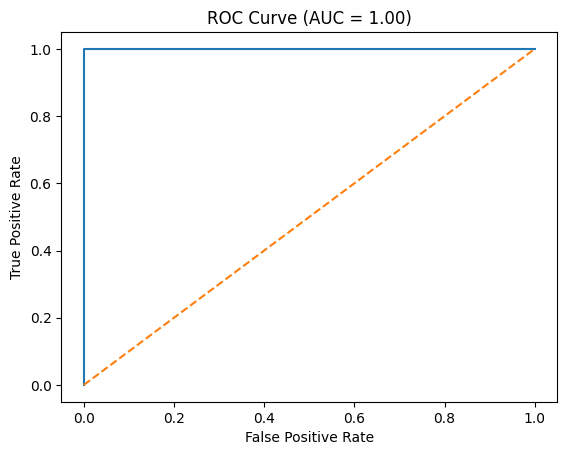

In [10]:
# RECEIVER-OPERATOR CHARACTERISTIC (ROC) CURVE - does the model rank sicker patients 
# higher than healthier ones?

from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt 

y_prob = model.predict_proba(x_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(f"ROC Curve (AUC = {roc_auc:.2f})")
plt.show()

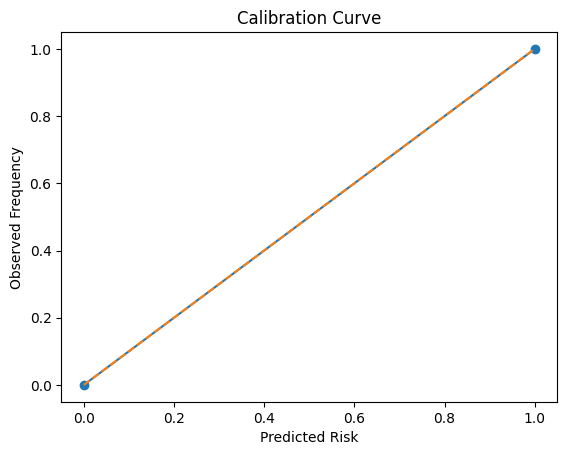

In [11]:
# CALIBRATION - ckecks; if model says 70% risk, does it actually mean 70% of those patients deteriorate?

from sklearn.calibration import calibration_curve 

prob_true, prob_pred = calibration_curve(y_test, y_prob, n_bins=5)

plt.plot(prob_pred, prob_true, marker='o')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel("Predicted Risk")
plt.ylabel("Observed Frequency")
plt.title("Calibration Curve")
plt.show()